# Grating couplers

In [9]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import gdsfactory as gf
import meep as mp
import gplugins.gmeep as gm
import gdsfactory.cross_section as xs
import gplugins.modes as gmode
import gplugins.gmeep as gmeep
import pandas as pd

Using MPI version 4.1, 1 processes
2025-10-24 18:01:50.627 | INFO     | gplugins.gmeep:<module>:39 - Meep '1.31.0' installed at ['/home/ramprakash/anaconda3/envs/si_photo/lib/python3.13/site-packages/meep']


## Rectangular grating coupler from GDSFactory

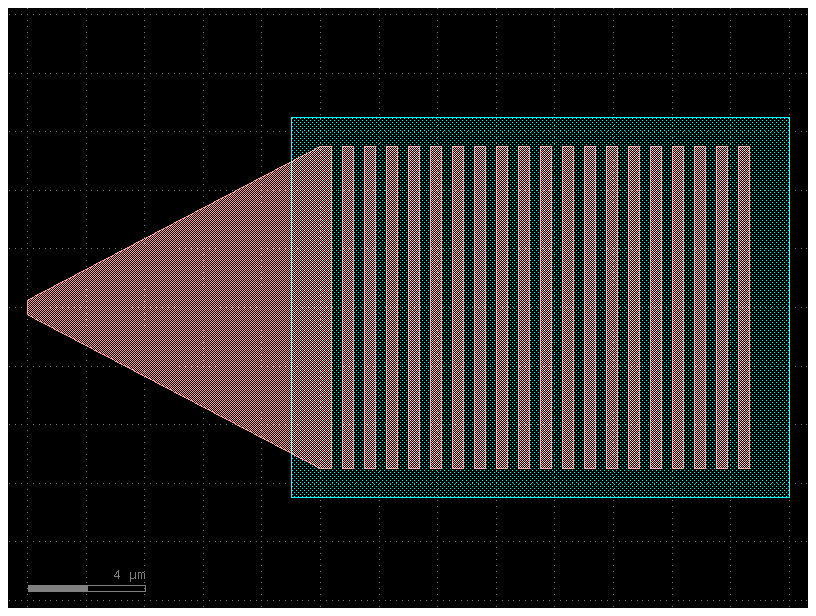

In [2]:
gf.clear_cache
rect_gc = gf.components.grating_coupler_rectangular(n_periods=20, period=0.75, fill_factor=0.5, width_grating=11.0, length_taper=10.0, polarization='te', wavelength=1.55, taper='taper', layer_slab='SLAB150', layer_grating=None, fiber_angle=15, slab_xmin=-1.0, slab_offset=1.0, cross_section='strip')
# rect_gc.draw_ports()
rect_gc.plot()

In [3]:
scene = rect_gc.to_3d()
scene.show()

## Using Gplugins gmeep for the uniform 2D grating coupling simulations

The effective the effective index of the 220 nm slab is about neff1 = 2.848, and the effective index of the shallow etched region with thickness 150 nm is about neff2 =2.534, at λ0 = 1550 nm. For the Fill fraction of 50%. 

The weighted-average index of the grating region, neffm is then 

$n_{eff} = FF.n_{eff1}+(1-ff).n_{eff2}$

$n_{eff} = 2.691$

From, the Bragg condition and for the incident angle in air is 20 deg

$\Lambda = \frac{\lambda}{n_{eff}-sin\theta_{air}}$

$\Lambda = 660 nm $ Period of the grating

In [4]:
help(gmeep.write_sparameters_grating)

Help on function write_sparameters_grating in module gplugins.gmeep.write_sparameters_grating:

write_sparameters_grating(
    plot: 'bool' = False,
    plot_contour: 'bool' = False,
    animate: 'bool' = False,
    overwrite: 'bool' = False,
    dirpath: 'PathType | None' = PosixPath('/home/ramprakash/.gdsfactory/sp'),
    decay_by: 'float' = 0.001,
    verbosity: 'int' = 0,
    **settings
) -> 'dict[str, np.ndarray]'
    Write grating coupler with fiber Sparameters.

    Args:
        plot: plot simulation (do not run).
        plot_contour: show contours.
        animate: create animation.
        overwrite: overwrites simulation if found.
        dirpath: directory path.
        decay_by: field decay to stop simulation.
        verbosity: print messages.
        core_materials: number of cores.

    Keyword Args:
        period: fiber grating period in um.
        fill_factor: fraction of the grating period filled with the grating material.
        n_periods: number of periods.
   

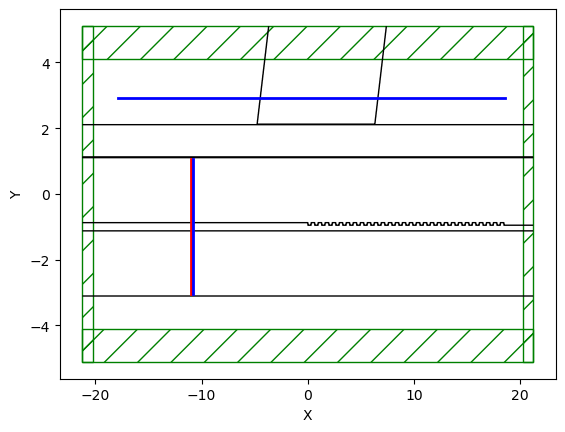

In [11]:
fiber_angle_deg = 20
period = 0.66
ff = 0.5
nSi = 3.45
nSiO2 = 1.45 
fiber_y_offset_air = 3
fiber_x_pos = 1
core_thickness = 0.220
slab_thickness = 0.150 
waveguide_port_x_offset = 10
n_periods = 30
start_wvl = 1.45
end_wvl = 1.65
gmeep.write_sparameters_grating(
    plot=True, 
    plot_contour=True, 
    fiber_angle_deg=fiber_angle_deg, 
    period=period, 
    fill_factor=ff, 
    nwg=nSi, 
    nslab=nSi, 
    nbox=nSiO2, 
    clad_material=nSiO2, 
    nsubstrate=nSi, 
    wavelength_start=start_wvl,
    wavelength_stop=end_wvl,
    fiber_xposition=fiber_x_pos, 
    waveguide_port_x_offset_from_grating_start=waveguide_port_x_offset,
    n_periods=n_periods
    )


In [ ]:
# Run simulation 
sp2 = gmeep.write_sparameters_grating(
    plot=False, 
    plot_contour=False, 
    fiber_angle_deg=fiber_angle_deg, 
    period=period, 
    fill_factor=ff, 
    nwg=nSi, 
    nslab=nSi, 
    nbox=nSiO2, 
    clad_material=nSiO2, 
    nsubstrate=nSi, 
    fiber_xposition=fiber_x_pos, 
    waveguide_port_x_offset_from_grating_start=waveguide_port_x_offset,
    n_periods=n_periods,
    wavelength_start=start_wvl,
    wavelength_stop=end_wvl,
    animate=True,
    dirpath = '/home/ramprakash/Integrated_Tests/GC_temp',
    resolution=20
    )

Maximum transmission is shifted from 1550 nm. Optimization of other parameters and higher resolution will give the desired trasnmission.

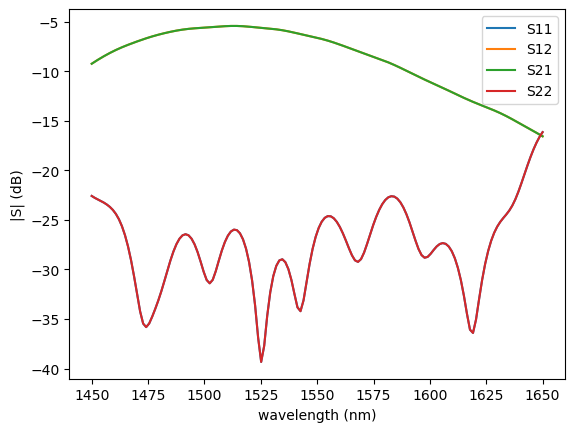

In [16]:
gmeep.plot.plot_sparameters(sp2)

<video width="640" height="240" 
       src="GC_temp/fiber_6e2b8ff2.mp4"  
       controls>
</video>

Futher studies can be done by varying the location of the fiber, changing the periods, fill fraction etc...

# Focusing coupler

To make compact coupler without tapper. 

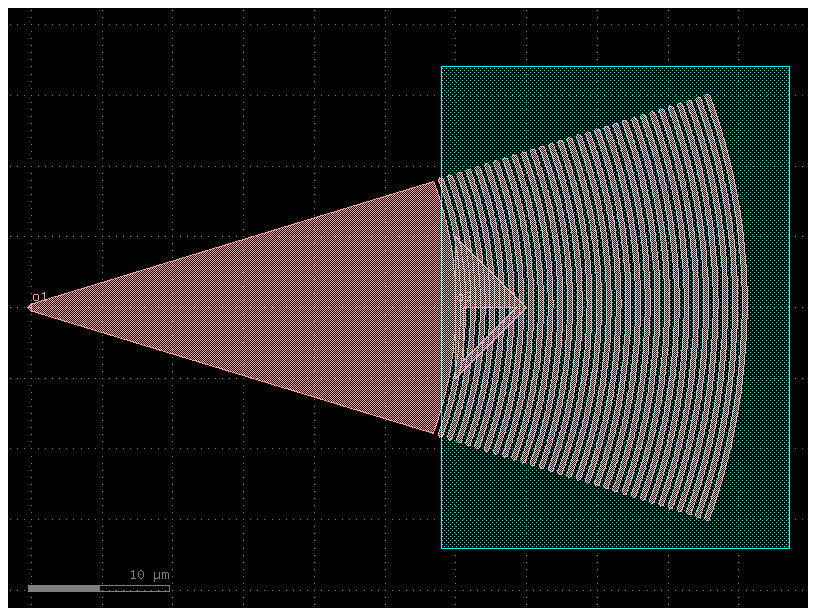

In [12]:
focus_coupler = gf.components.grating_coupler_elliptical(polarization='te', taper_length=30, taper_angle=40, wavelength=1.554, fiber_angle=15, grating_line_width=0.343, neff=2.638, nclad=1.443, n_periods=30, big_last_tooth=False, layer_slab='SLAB150', slab_xmin=-1, slab_offset=2, spiked=True, cross_section='strip').copy()
focus_coupler.draw_ports()
focus_coupler.plot()

In [13]:
scene = focus_coupler.to_3d()
scene.show()

## Modeling with MEEP

Trying 3D simulations from the GDSfactory component

In [7]:
%%writefile fgc_MPI_sim.py
import gplugins.modes as gmode
import numpy as np
import matplotlib.pyplot as plt
import meep as mp
import gdsfactory as gf
import gplugins.gmeep as gm
import gdsfactory.cross_section as xs
import sys

mp.verbosity(3)
sys.stdout.flush()


# Set up frequency points for simulation
npoints = 50
lcen = 1.492
dlam = 0.100
wl = np.linspace(lcen - dlam / 2, lcen + dlam / 2, npoints)
fcen = 1 / lcen
fwidth = 3 * dlam / lcen**2
fpoints = 1 / wl

# Center frequency mode_parity
mode_parity = mp.ODD_Y #mp.EVEN_Y + mp.ODD_Z
dpml = 2
dpad = 2
resolution = 10

# Define materials
Si = mp.Medium(index=3.45)
SiO2 = mp.Medium(index=1.45)

focus_coupler = gf.components.grating_coupler_elliptical(polarization='tm', taper_length=16.6, taper_angle=40, wavelength=1.554, fiber_angle=15, grating_line_width=0.343, neff=2.638, nclad=1.45, n_periods=30, big_last_tooth=False, layer_slab='SLAB150', slab_xmin=-1, slab_offset=2, spiked=True, cross_section='strip').copy()

sub_t = 2
sio_t = 2
si_t = 0.220
air_t = 1
cladding_t = 1
sx = focus_coupler.xsize + 2 * dpml + 2
sy = focus_coupler.ysize + 2 * dpml + 2 * dpad
sz = 2*(sub_t+sio_t+si_t+dpml+air_t)

# Cell size
cell_size = mp.Vector3(sx,sy,sz)

# Create the ring resonator component
focus_coupler = gf.components.extend_ports(focus_coupler, port_names=["o1"], length=6)
focus_coupler = focus_coupler.copy()
focus_coupler.flatten()
focus_coupler.center = (0, 0)

# Get geometry from component
coupler_geo = gm.get_meep_geometry.get_meep_geometry_from_component(focus_coupler, is_3d=True)

geometry = []

# SiO2 cladding
geometry.append(
   mp.Block(
    center=mp.Vector3(0, 0, si_t/2),
    size=(mp.inf, mp.inf, cladding_t),
    material=SiO2
  )  
)

# GC geometry
geometry += [
    mp.Prism(geom.vertices, geom.height, geom.axis, geom.center, material=Si)
    for geom in coupler_geo
]

# geometry.append(geom_coupler)

# SiO2 slab 
geometry.append(
  mp.Block(center=mp.Vector3(0, 0, -sio_t/2), size=(mp.inf, mp.inf, sio_t), material=SiO2)  
)

# Si substrate 
geometry.append(
  mp.Block(center=mp.Vector3(0, 0, -sio_t-sub_t/2), size=(mp.inf, mp.inf, sub_t), material=Si)  
)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
  mp.EigenModeSource(
    src=src,
    eig_band=1,
    eig_parity=mode_parity,
    eig_kpoint=mp.Vector3(1,0,0),
    direction=mp.NO_DIRECTION,
    size=mp.Vector3(0,1,si_t+sio_t),
    center=mp.Vector3(focus_coupler.ports["o1"].x+dpml+2, focus_coupler.ports["o1"].y, 0),
    amplitude=1
),
]
symmetries = [mp.Mirror(mp.Y,-1)]
sim = mp.Simulation(
    resolution=resolution,
    cell_size=cell_size,
    boundary_layers=[mp.Absorber(dpml)],
    sources=source,
    geometry=geometry,
    dimensions=3,
    symmetries=symmetries
)

waveguide_monitor_port = mp.ModeRegion(
  size=mp.Vector3(0,1,si_t+sio_t),
    center=mp.Vector3(focus_coupler.ports["o1"].x+dpml+2+1, focus_coupler.ports["o1"].y, 0),
)
waveguide_monitor = sim.add_mode_monitor(fpoints, waveguide_monitor_port)

fiber_monitor_port = mp.ModeRegion(
  size=mp.Vector3(focus_coupler.xsize/2,focus_coupler.ysize,0),
  center=mp.Vector3(30*0.3,0,sio_t+air_t)
)
fiber_monitor = sim.add_mode_monitor(fpoints, fiber_monitor_port)

whole_dft = sim.add_dft_fields([mp.Ey], fcen, 0, 1, center=mp.Vector3(0,0,0), size=mp.Vector3(sx,0,sz)) 
whole_dft_2 = sim.add_dft_fields([mp.Ey], fcen, 0, 1, center=mp.Vector3(0, 0, 0.160), size=mp.Vector3(sx, sy,0),)

vol1 = mp.Volume(
    center=mp.Vector3(0, 0, 0),
    size=mp.Vector3(sx, 0,sz)
    )
vol2 = mp.Volume(
    center=mp.Vector3(0, 0, 0.160),
    size=mp.Vector3(sx, sy,0),)

if mp.am_master():
  eps_parameters = dict(contour=True)
  sim.plot2D(output_plane=vol1, eps_parameters=eps_parameters,labels=True)
  plt.savefig('Grating_coupler_sim.png', dpi=150, bbox_inches='tight')
  plt.close()
  eps_parameters = dict(contour=True)
  sim.plot2D(output_plane=vol2, eps_parameters=eps_parameters,labels=True)
  plt.savefig('Grating_coupler_sim_2.png', dpi=150, bbox_inches='tight')
  plt.close()

def progress(sim):
    if mp.am_master():
        print(f"t = {sim.meep_time():.1f}")
        sys.stdout.flush()
        
sim.run(mp.at_every(10, progress),
 until_after_sources=mp.stop_when_energy_decayed(dt=50, decay_by=1e-4))
 
#  mp.stop_when_fields_decayed(
  # 20, mp.Ey, mp.Vector3(focus_coupler.ports["o1"].x+dpml+2,0,0), 1e-6))

# waveguide_mode = sim.get_eigenmode_coefficients(
#         waveguide_monitor,
#         [1],
#         eig_parity=mode_parity,
#         direction=mp.X,
#         eig_tolerance=5E-5,)
# fiber_angle_deg = 15
# n_eff = 1.45
# fiber_mode = sim.get_eigenmode_coefficients(
#     fiber_monitor,
#     [1],
#     direction=mp.NO_DIRECTION,
#     eig_parity=mode_parity,
#     eig_tolerance=5E-5,
#     kpoint_func = lambda f, n: mp.Vector3(
#     2 * np.pi * f * n_eff * np.sin(np.radians(fiber_angle_deg)),
#     0,
#     2 * np.pi * f * n_eff * np.cos(np.radians(fiber_angle_deg))
# ),  # Hardcoded index for now, pull from simulation eventually
# )

# a1 = waveguide_mode.alpha[:, :, 0].flatten()
# b1 = waveguide_mode.alpha[:, :, 1].flatten()
# a2 = fiber_mode.alpha[:, :, 0].flatten()
# eps_data = sim.get_epsilon(center=mp.Vector3(0,0,0), size=mp.Vector3(sx,0,sz))
ez_data = sim.get_dft_array(whole_dft,mp.Ey,0)
# eps_data_2 = sim.get_epsilon(center=mp.Vector3(0, 0, 0.160), size=mp.Vector3(sx, sy,0))
ez_data_2 = sim.get_dft_array(whole_dft_2,mp.Ey,0)
# s11 = np.squeeze(b1 / a1)
# s12 = np.squeeze(a2 / a1)
# s21 = s12
# s22 = s11

# Save results (only from master process)
if mp.am_master():
  # np.save('fgc_wavelengths.npy', wl)
  # np.save('fgc_s11.npy', s11)
  # np.save('fgc_s12.npy', s12)
  # np.save('fgc_eps_data.npy', eps_data)
  np.save('fgc_ez_data.npy', ez_data)
  # np.save('fgc_eps_data_2.npy', eps_data_2)
  np.save('fgc_ez_data_2.npy', ez_data_2)
  
  # Create field plot
  fig = plt.figure(figsize=(12, 8))
  ax_field = fig.add_subplot(1, 1, 1)
  ax_field.set_title("Steady State Fields")
  # ax_field.imshow(
  #     np.flipud(np.transpose(eps_data)),
  #     interpolation="spline36",
  #     cmap="binary"
  # )

  ax_field.imshow(
      np.flipud(np.transpose(np.real(ez_data))),
      interpolation="spline36",
      cmap="RdBu",
      alpha=0.9,
  )
  ax_field.axis("off")
  plt.savefig('fgc_steady_state_fields.png', dpi=150, bbox_inches='tight')
  plt.close()
  fig = plt.figure(figsize=(12, 8))
  ax_field = fig.add_subplot(1, 1, 1)
  ax_field.set_title("Steady State Fields")
  # ax_field.imshow(
  #     np.flipud(np.transpose(eps_data)),
  #     interpolation="spline36",
  #     cmap="binary"
  # )

  ax_field.imshow(
      np.flipud(np.transpose(np.real(ez_data_2))),
      interpolation="spline36",
      cmap="RdBu",
      alpha=0.9,
  )
  ax_field.axis("off")
  plt.savefig('fgc_steady_state_fields_2.png', dpi=150, bbox_inches='tight')
  plt.close()
  print("Simulation completed successfully!")
  print(f"Results saved to: wavelengths.npy, port1_coeff.npy, port2_coeff.npy, eps_data.npy, ez_data.npy")
  print(f"Plots saved to: simulation_geometry.png, steady_state_fields.png")


Overwriting fgc_MPI_sim.py


<Axes: xlabel='X', ylabel='Y'>

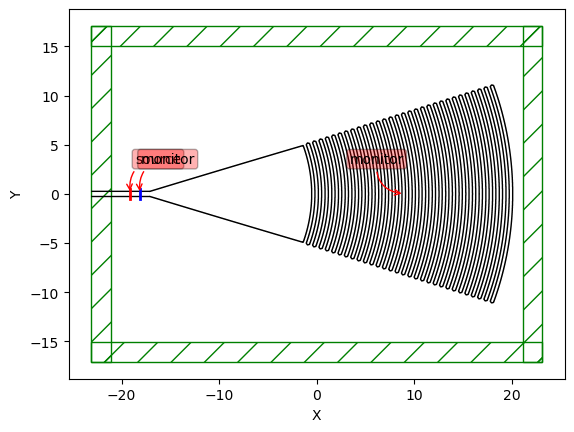

In [22]:
vol1 = mp.Volume(
    center=mp.Vector3(0, 0, 0.160),
    size=mp.Vector3(sx, sy,0),)
eps_parameters = dict(contour=True)
sim.plot2D(output_plane=vol1, eps_parameters=eps_parameters,labels=True)

In [ ]:
!mpirun -np 34 python fgc_MPI_sim.py

Due to computational cost for mode decompostion only the steady state fields are calculated. 

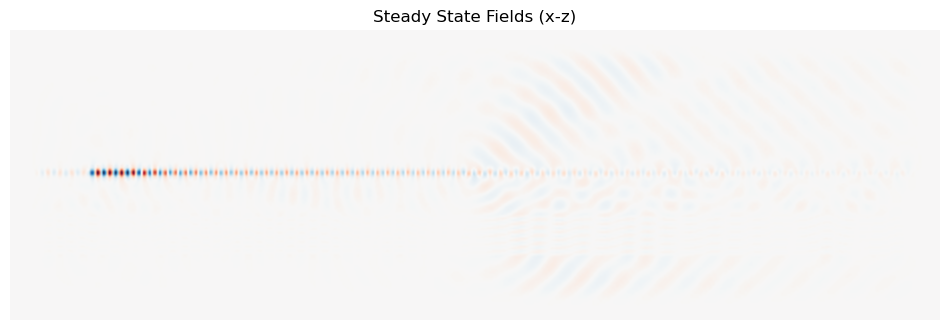

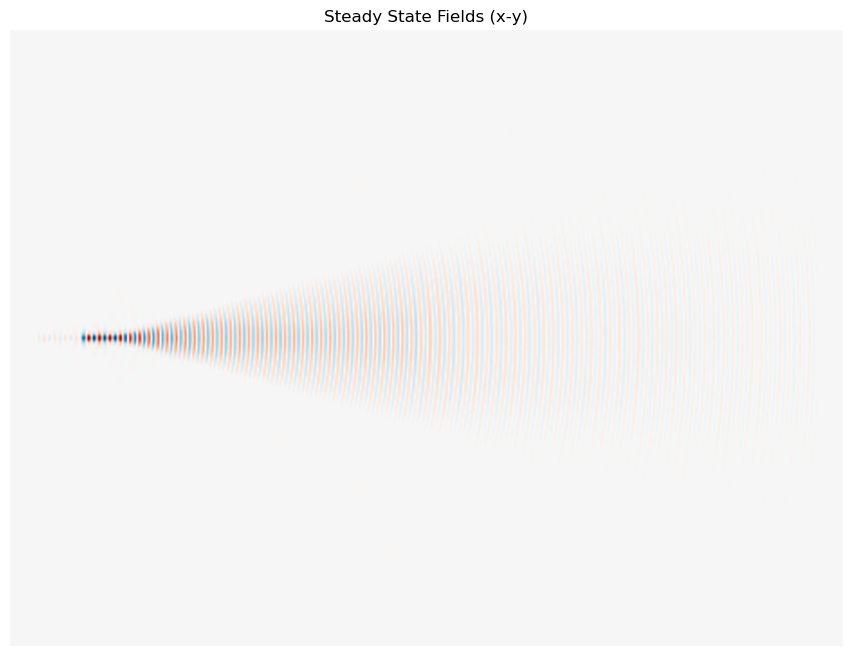

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Load results
# wl = np.load('fgc_wavelengths.npy')
# port1_coeff = np.load('fgc_s11.npy')
# port2_coeff = np.load('fgc_s12.npy')
# port3_coeff = np.load('RingDob_port3_coeff.npy')
# port4_coeff = np.load('RingDob_port4_coeff.npy')
# eps_data = np.load('RingDob_eps_data.npy')
ez_data = np.load('fgc_ez_data.npy')
ez_data_2 = np.load('fgc_ez_data_2.npy')

# # Plot transmission spectrum
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

# # S11 (reflection)
# ax1.plot(wl, 10*np.log10(np.abs(port1_coeff)**2), 'b-', linewidth=2)
# ax1.set_ylabel('Reflectance |S11|²')
# ax1.set_title('Port 1 Reflection')
# ax1.grid(True, alpha=0.3)

# # S21 (transmission)
# ax2.plot(wl, 10*np.log10(np.abs(port2_coeff)**2), 'r-', linewidth=2)
# ax2.set_xlabel('Wavelength (μm)')
# ax2.set_ylabel('Transmittance |S21|²')
# ax2.set_title('Port 2 Transmission')
# ax2.grid(True, alpha=0.3)

# # S31 (transmission)
# ax3.plot(wl, 10*np.log10(np.abs(port3_coeff)**2), 'r-', linewidth=2)
# ax3.set_xlabel('Wavelength (μm)')
# ax3.set_ylabel('Transmittance |S31|²')
# ax3.set_title('Port 3 Transmission')
# ax3.grid(True, alpha=0.3)

# # S41 (transmission)
# ax4.plot(wl, 10*np.log10(np.abs(port4_coeff)**2), 'r-', linewidth=2)
# ax4.set_xlabel('Wavelength (μm)')
# ax4.set_ylabel('Transmittance |S41|²')
# ax4.set_title('Port 4 Transmission')
# ax4.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.savefig('transmission_spectrum.png', dpi=150, bbox_inches='tight')
# plt.show()

# print(f"Peak transmission: {np.min(np.abs(port2_coeff)**2):.4f}")
# print(f"Resonance wavelength: {wl[np.argmin(np.abs(port2_coeff)**2)]:.4f} μm")

fig = plt.figure(figsize=(12, 8))
ax_field = fig.add_subplot(1, 1, 1)
ax_field.set_title("Steady State Fields (x-z)")
# ax_field.imshow(
#      np.flipud(np.transpose(eps_data)),
#       interpolation="spline36",
#       cmap="binary")
ax_field.imshow(
    np.flipud(np.transpose(np.real(ez_data))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()
fig = plt.figure(figsize=(12, 8))
ax_field = fig.add_subplot(1, 1, 1)
ax_field.set_title("Steady State Fields (x-y)")
# ax_field.imshow(
#      np.flipud(np.transpose(eps_data)),
#       interpolation="spline36",
#       cmap="binary")
ax_field.imshow(
    np.flipud(np.transpose(np.real(ez_data_2))),
    interpolation="spline36",
    cmap="RdBu",
    alpha=0.9,
)
ax_field.axis("off")
plt.show()

TODO: More simualtion for the far-field coupling angle and optmization